In [22]:
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

import functions.eddy_feedback as ef
import functions.data_wrangling as dw

# JRA55 6-hourly data

In [23]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/6h_processed'
data_dir = os.path.join(path, 'jra55_6h-mm_uvtw_epf-pr_1958-2016.nc')
ds = xr.open_dataset(data_dir)
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 708, level: 37, lat: 73, lon: 144)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 584B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * level    (level) float64 296B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2016-12-01
Data variables:
    u        (time, level, lat, lon) float32 1GB ...
    v        (time, level, lat, lon) float32 1GB ...
    t        (time, level, lat, lon) float32 1GB ...
    omega    (time, level, lat, lon) float32 1GB ...
    ubar     (time, level, lat) float32 8MB ...
    ep1_pr   (time, level, lat) float64 15MB ...
    ep2_pr   (time, level, lat) float64 15MB ...
    div1_pr  (time, level, lat) float64 15MB ...
    div2_pr  (time, level, lat) float64 15MB ...

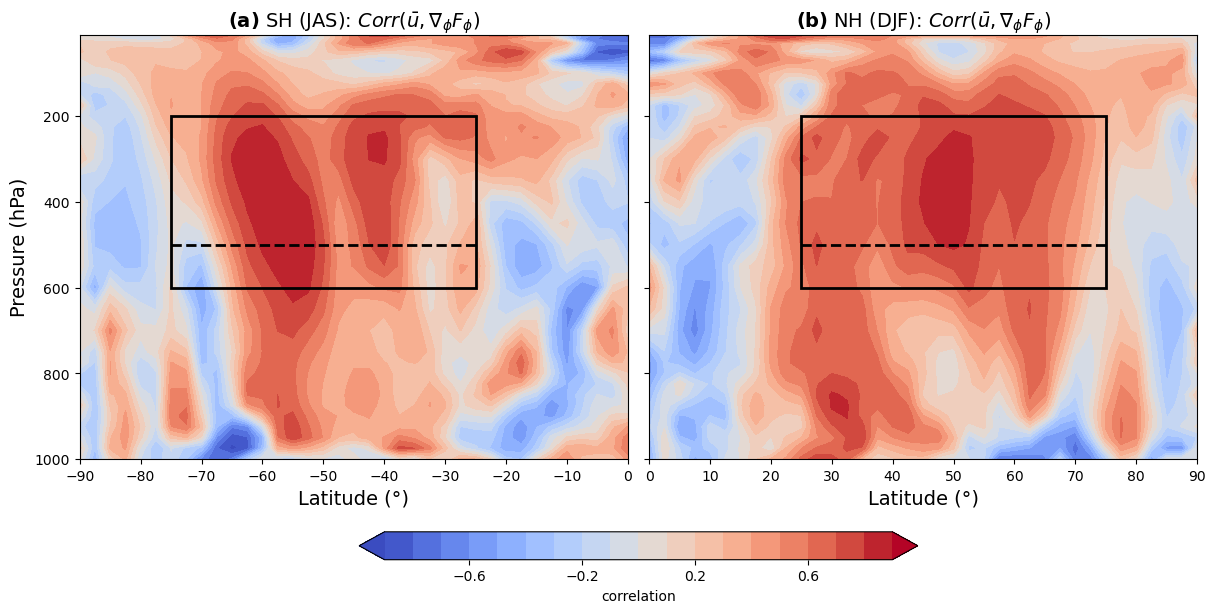

In [30]:
def plot_reanalysis_correlation_both_hemispheres(
        ds, logscale=True, show_rect=True,
        top_atmos=10., cut_poles=False, figsize=(12, 6),
        take_seasonal=True, which_div1='div1_pr', if_save=False):
    """
    Plot correlation between ubar and div1 for both hemispheres side by side.
    """

    def process_hemisphere(ds, lat, season, rect_box):
        hemi_ds = ds.where(ds.lat >= 0., drop=True) if lat == 'NH' else ds.where(ds.lat <= 0., drop=True)
        if take_seasonal:
            hemi_ds = hemi_ds.sel(time=slice('1979', '2016'))
            hemi_ds = dw.seasonal_mean(hemi_ds, season=season)

        ubar = hemi_ds.ubar
        div1 = hemi_ds[which_div1]
        corr = xr.corr(div1, ubar, dim='time')
        corr = corr.where(corr.level >= top_atmos, drop=True)
        if cut_poles:
            corr = corr.where(corr.lat >= -85., drop=True)
            corr = corr.where(corr.lat <= 85., drop=True)
        return corr, rect_box

    # Process hemispheres
    corr_sh, rect_box_sh = process_hemisphere(ds, 'SH', 'jas', (-75., 600.))
    corr_nh, rect_box_nh = process_hemisphere(ds, 'NH', 'djf', (25., 600.))

    # --- Plotting ---
    fig, axes = plt.subplots(
        ncols=2,
        figsize=figsize,
        sharey=True,
        constrained_layout=True   # key change
    )

    # Tighten spacing between the two hemispheric panels
    fig.set_constrained_layout_pads(w_pad=0.02)

    # Invert and scale shared y-axis on the first axis only
    if logscale:
        axes[0].set_yscale('log')
    axes[0].invert_yaxis()

    for ax, corr, rect_box, hemi_label in zip(
            axes,
            [corr_sh, corr_nh],
            [rect_box_sh, rect_box_nh],
            ['$\\bf{(a)}$ SH (JAS): $Corr(\\bar{{u}}, \\nabla_{\\phi} F_{\\phi})$',
             '$\\bf{(b)}$ NH (DJF): $Corr(\\bar{{u}}, \\nabla_{\\phi} F_{\\phi})$']):

        cf = ax.contourf(
            corr.lat, corr.level, corr, cmap='coolwarm',
            levels=np.linspace(-0.9, 0.9, 19), extend='both'
        )
        
        
        # --- Hemisphere-aware horizontal line at 500 hPa ---
        if "SH" in hemi_label:
            xmin, xmax = -75, -25   # SH
        else:
            xmin, xmax = 25, 75     # NH

        ax.hlines(
            y=500,
            xmin=xmin,
            xmax=xmax,
            colors='k',
            linestyles='--',
            linewidth=2
        )

        ax.set_xlabel('Latitude (°)', fontsize=14)
        ax.set_title(hemi_label, fontsize=14)

        if show_rect:
            rect = patches.Rectangle(rect_box, 50, -400, fill=False, linewidth=2)
            ax.add_patch(rect)

    # Shared y-label (only left panel)
    if logscale:
        axes[0].set_ylabel('Log pressure (hPa)', fontsize=14)
    else:
        axes[0].set_ylabel('Pressure (hPa)', fontsize=14)

    # Remove label on right axis
    axes[1].set_ylabel('')

    # Shared colorbar
    cbar = fig.colorbar(
        cf, ax=axes,
        location='bottom', orientation='horizontal',
        shrink=0.5, label='correlation', extend='both',
        ticks=[-0.6, -0.2, 0.2, 0.6]
    )
    
    if if_save:
        plt.savefig('/home/links/ct715/eddy_feedback/chapter1/zz_paper_plots/plots/correlations_efp_hemis.png', dpi=300)

    plt.show()
plot_reanalysis_correlation_both_hemispheres(ds, logscale=False, if_save=True)

# Compare colourmaps

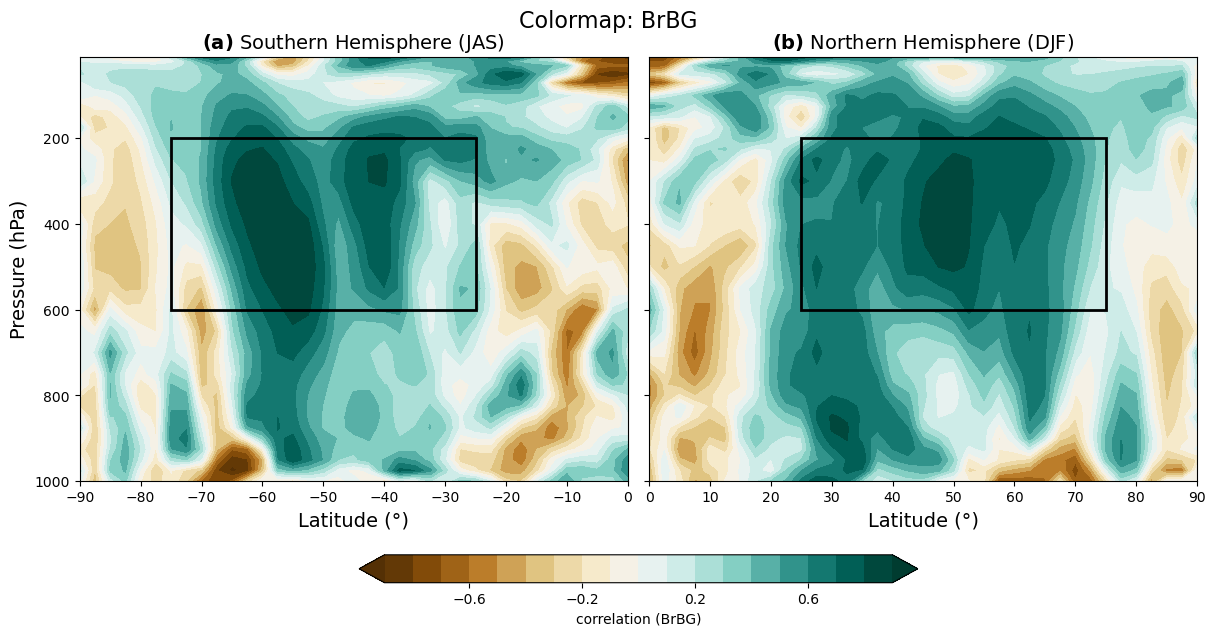

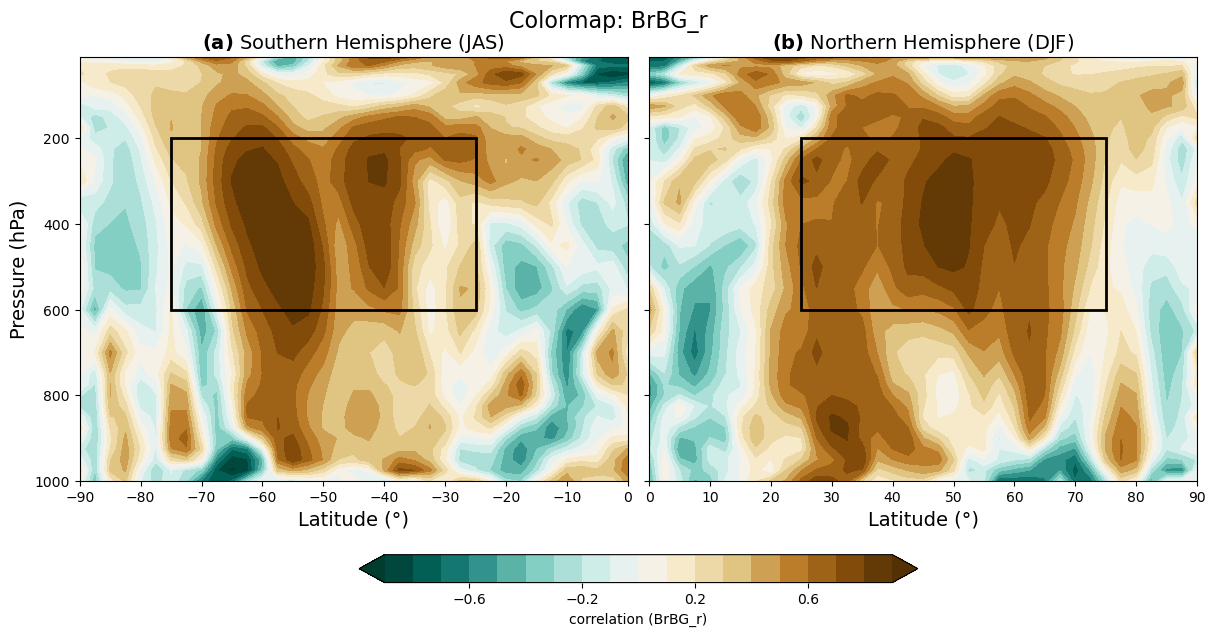

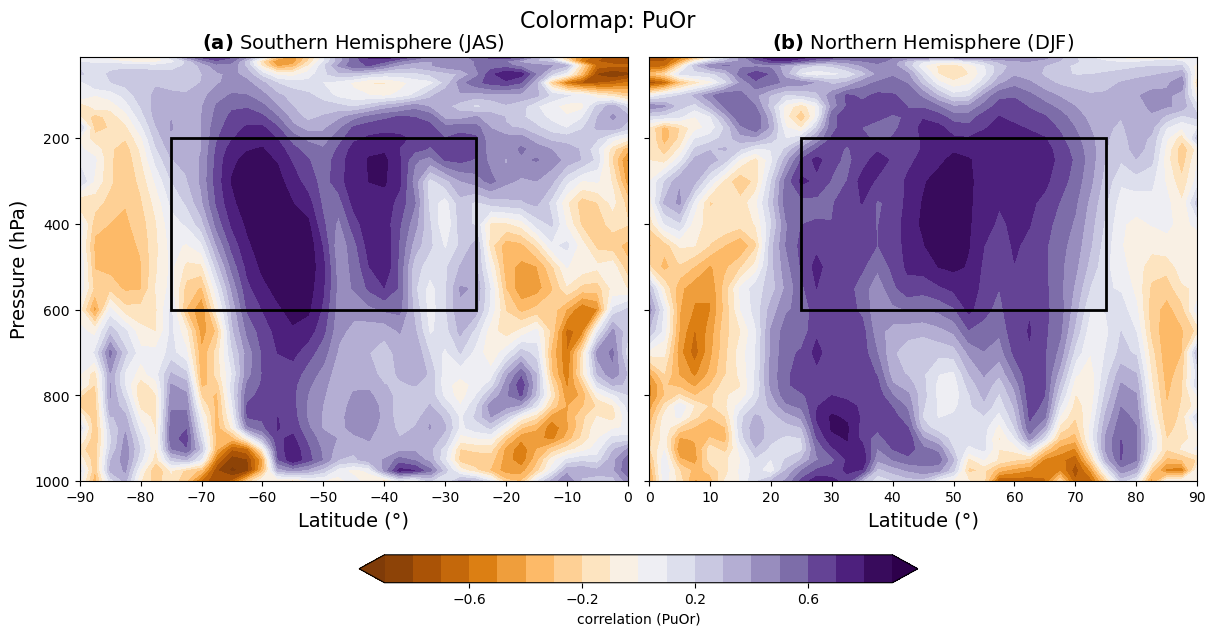

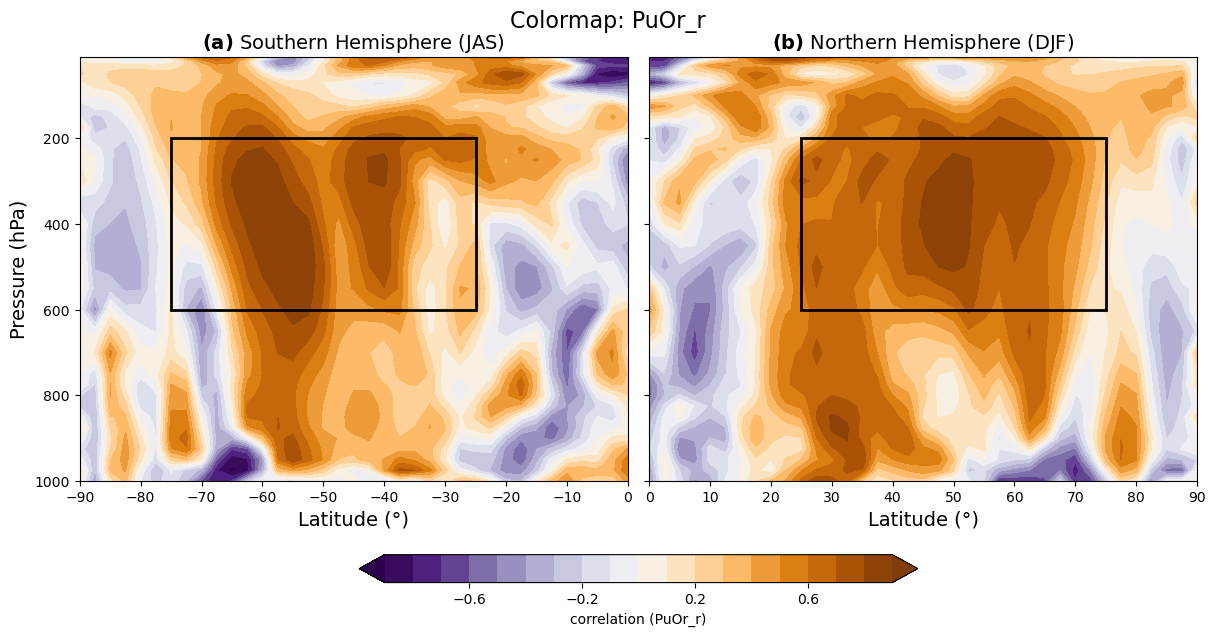

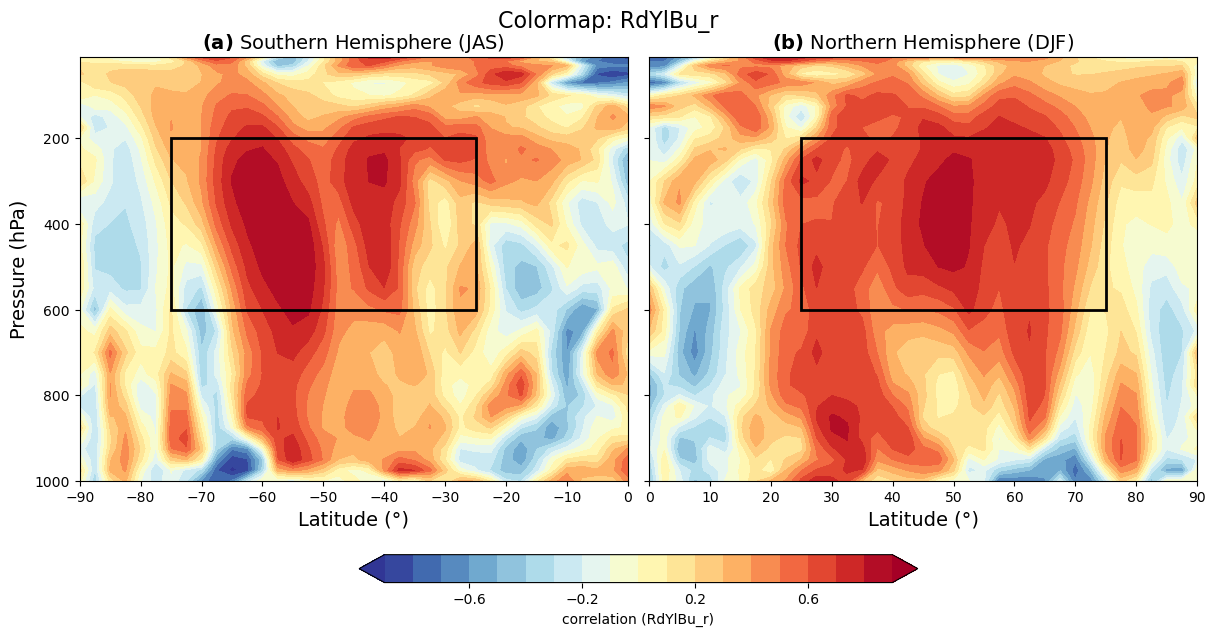

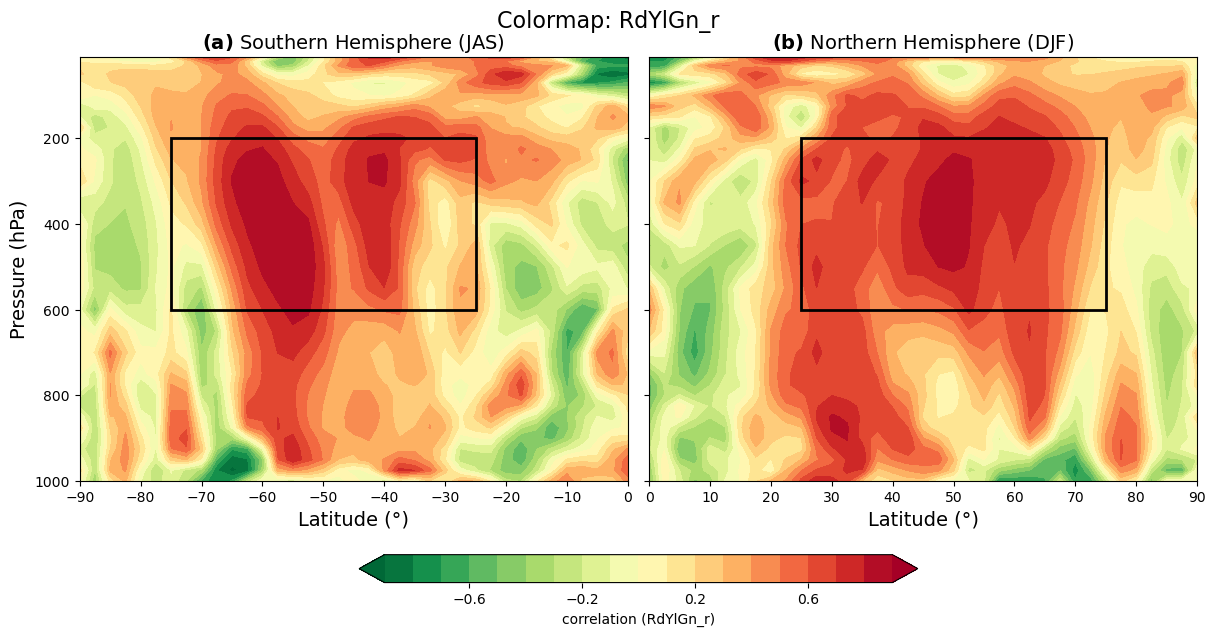

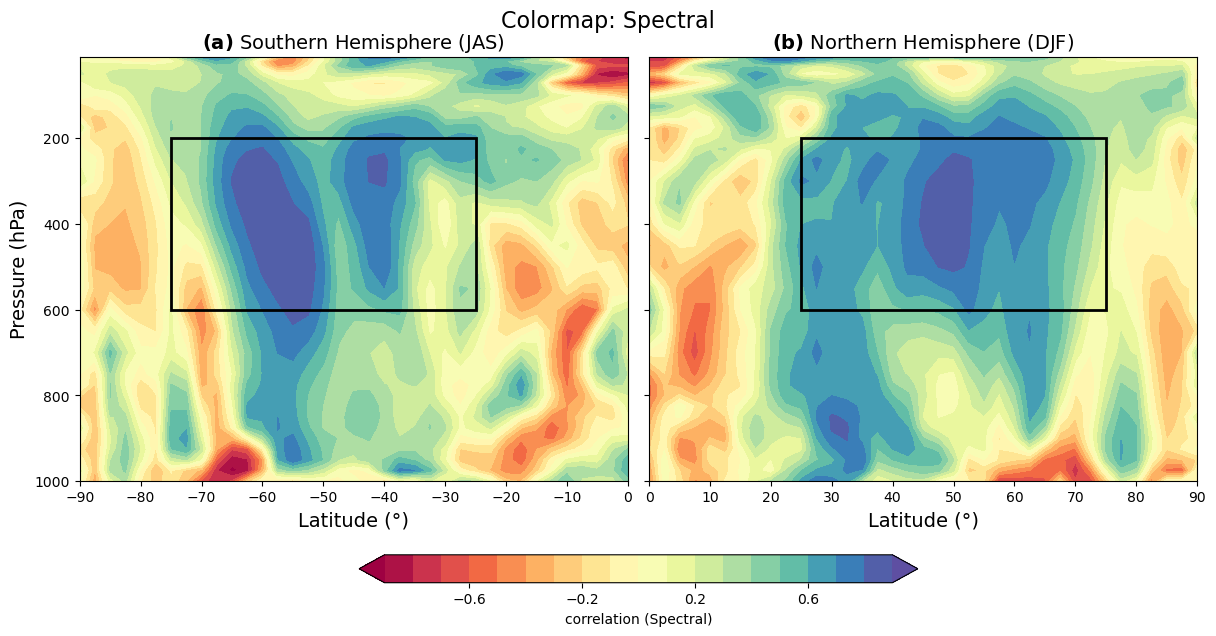

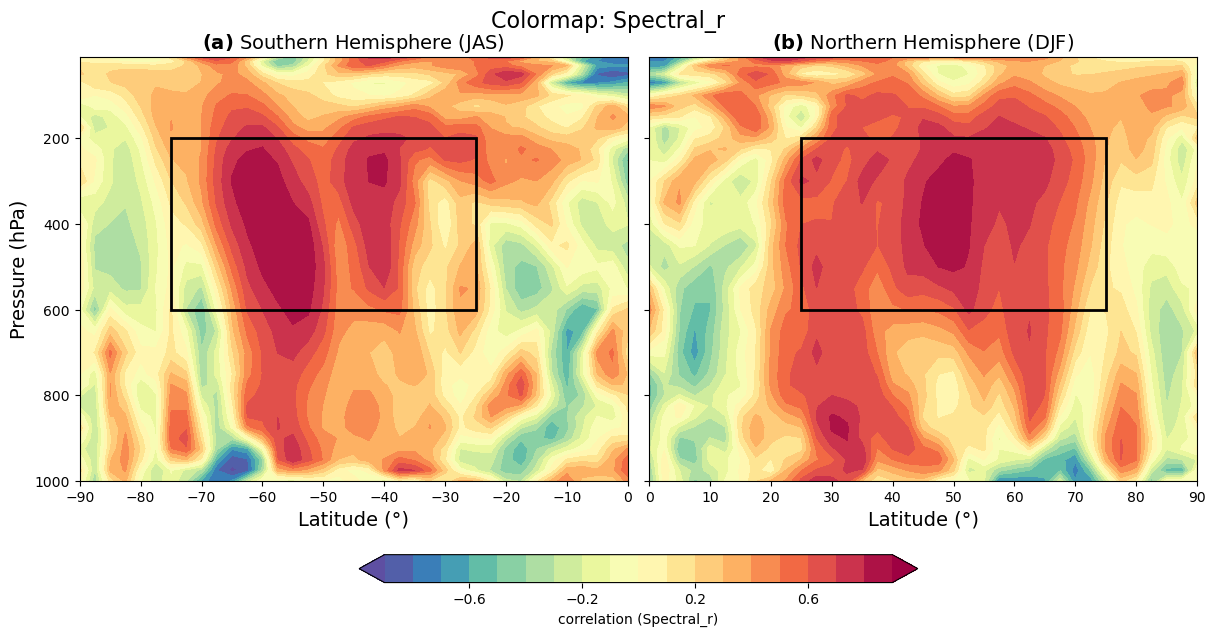

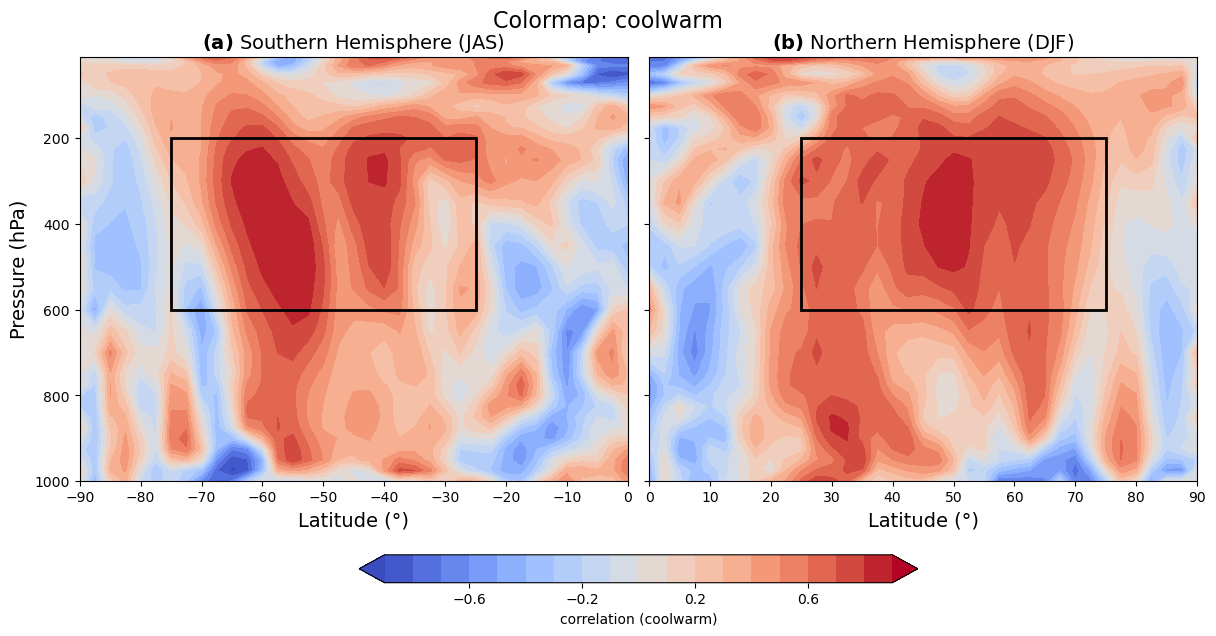

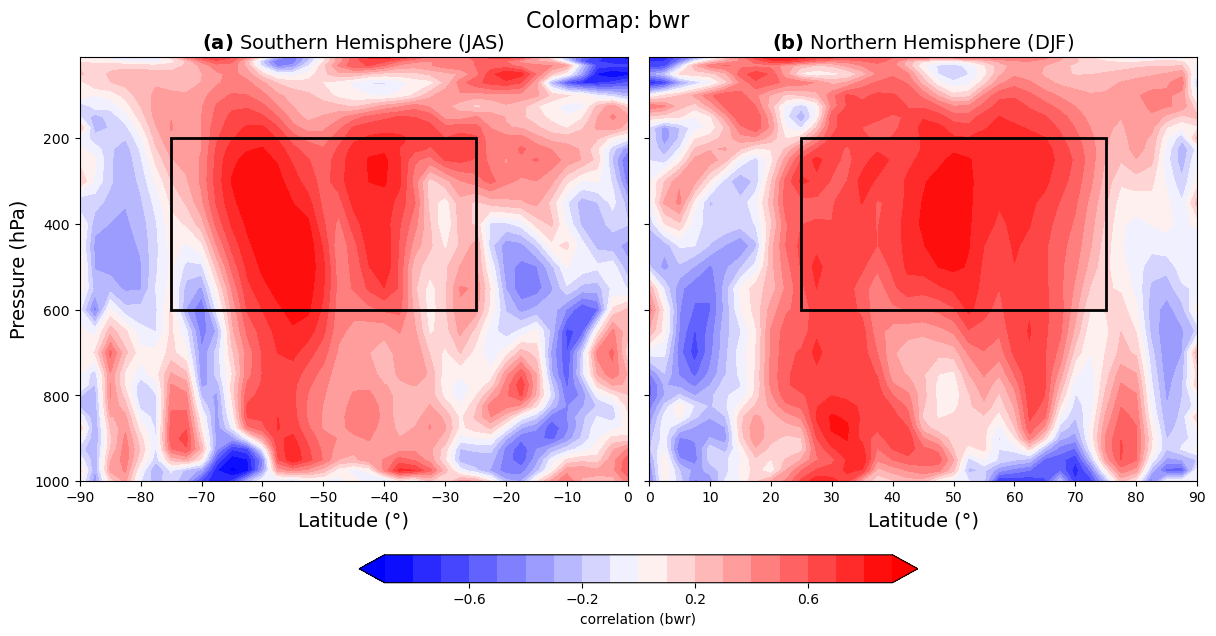

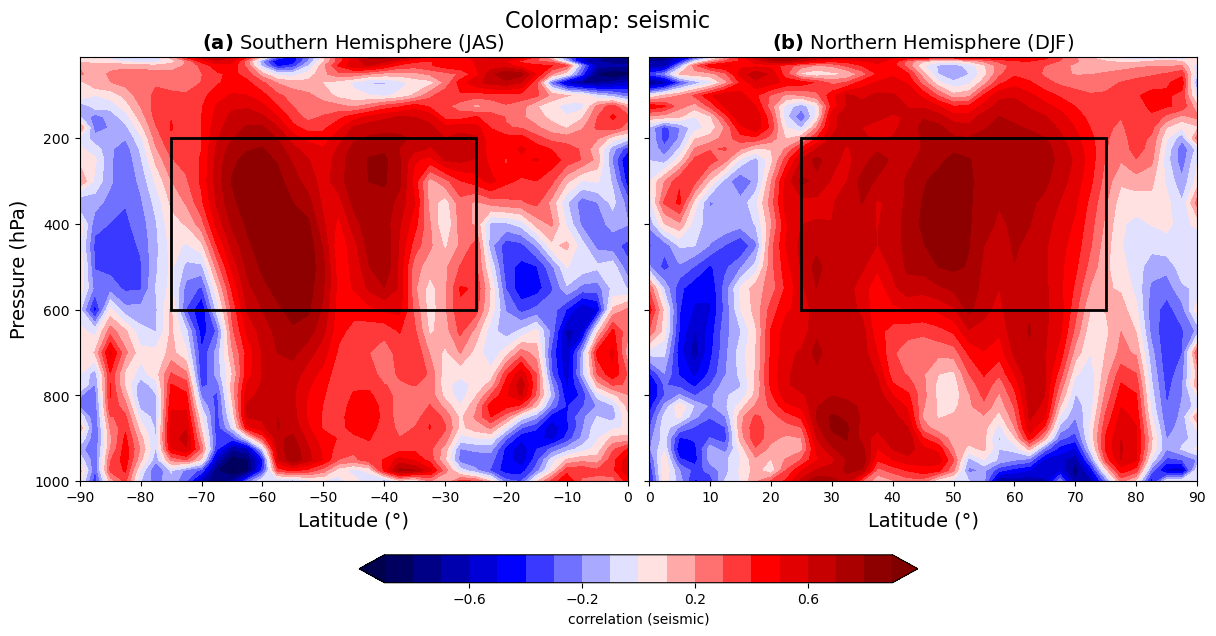

In [25]:
def plot_reanalysis_correlation_both_hemispheres(
        ds, cmap_name='RdBu_r', logscale=True, show_rect=True,
        top_atmos=10., cut_poles=False, figsize=(12, 6),
        take_seasonal=True, which_div1='div1_pr'):

    """
    Plot correlation between ubar and div1 for both hemispheres side by side,
    using a specified matplotlib colormap (cmap_name).
    """

    def process_hemisphere(ds, lat, season, rect_box):
        hemi_ds = ds.where(ds.lat >= 0., drop=True) if lat == 'NH' else ds.where(ds.lat <= 0., drop=True)
        if take_seasonal:
            hemi_ds = hemi_ds.sel(time=slice('1979', '2016'))
            hemi_ds = dw.seasonal_mean(hemi_ds, season=season)

        ubar = hemi_ds.ubar
        div1 = hemi_ds[which_div1]
        corr = xr.corr(div1, ubar, dim='time')
        corr = corr.where(corr.level >= top_atmos, drop=True)
        if cut_poles:
            corr = corr.where(corr.lat >= -85., drop=True)
            corr = corr.where(corr.lat <= 85., drop=True)
        return corr, rect_box

    # Process hemispheres
    corr_sh, rect_box_sh = process_hemisphere(ds, 'SH', 'jas', (-75., 600.))
    corr_nh, rect_box_nh = process_hemisphere(ds, 'NH', 'djf', (25., 600.))

    # --- Plotting ---
    fig, axes = plt.subplots(
        ncols=2,
        figsize=figsize,
        sharey=True,
        constrained_layout=True
    )

    fig.set_constrained_layout_pads(w_pad=0.02)

    # shared y-axis
    if logscale:
        axes[0].set_yscale('log')
    axes[0].invert_yaxis()

    for ax, corr, rect_box, hemi_label in zip(
            axes,
            [corr_sh, corr_nh],
            [rect_box_sh, rect_box_nh],
            ['$\\bf{(a)}$ Southern Hemisphere (JAS)',
             '$\\bf{(b)}$ Northern Hemisphere (DJF)']):

        cf = ax.contourf(
            corr.lat, corr.level, corr, cmap=cmap_name,
            levels=np.linspace(-0.9, 0.9, 19), extend='both'
        )

        ax.set_xlabel('Latitude (°)', fontsize=14)
        ax.set_title(hemi_label, fontsize=14)

        if show_rect:
            rect = patches.Rectangle(rect_box, 50, -400, fill=False, linewidth=2)
            ax.add_patch(rect)

    # y-label (shared)
    axes[0].set_ylabel('Log pressure (hPa)' if logscale else 'Pressure (hPa)', fontsize=14)

    # remove duplicated label
    axes[1].set_ylabel('')

    # Shared colorbar
    cbar = fig.colorbar(
        cf, ax=axes,
        location='bottom', orientation='horizontal',
        shrink=0.5, label=f'correlation ({cmap_name})',
        extend='both', ticks=[-0.6, -0.2, 0.2, 0.6]
    )

    # Write the colormap name clearly
    fig.suptitle(f"Colormap: {cmap_name}", fontsize=16, y=1.03)

    plt.show()

diverging_maps = [
    'BrBG', 'BrBG_r', 'PuOr', 'PuOr_r',
    'RdYlBu_r', 'RdYlGn_r', 'Spectral', 'Spectral_r', 'coolwarm',
    'bwr', 'seismic'
]

for cmap in diverging_maps:
    plot_reanalysis_correlation_both_hemispheres(
        ds,
        cmap_name=cmap,
        logscale=False
    )